# Multi-Armed Bandits


The multi-armed bandit problem is a fundamental framework in reinforcement learning that captures the exploration-exploitation trade-off. Named after slot machines \(one-armed bandits\), it models scenarios where an agent must choose between multiple options with unknown reward distributions.

# Multi-Armed Bandits

**Chapter 1: Exploration vs Exploitation in Sequential Decision Making**

The multi-armed bandit problem is a fundamental framework in reinforcement learning that captures the exploration-exploitation trade-off. Named after slot machines (one-armed bandits), it models scenarios where an agent must choose between multiple options with unknown reward distributions.

## Problem Formulation

A $k$-armed bandit has $k$ possible actions (arms). Each arm $i$ has an unknown expected reward:

$$q_*(a) = \mathbb{E}[R_t | A_t = a]$$

At each timestep $t$, the agent:
1. Selects an action $A_t$
2. Receives reward $R_t$

A real-world scenario would be a game-show where there are $n$ levers to pull. With each pull, the player gets a random reward. The goal is to maximize the cumulative reward.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

## Bandit Environment

We'll create a simple $k$-armed bandit where each arm returns rewards from a Gaussian distribution. In terms of our real-world example, pulling lever $a$ provides a reward $R(a)$ sampled from a Gaussian whose mean depends on $a$ (choice of lever).
$$R(a) \sim N(q_{*}(a), \sigma)$$

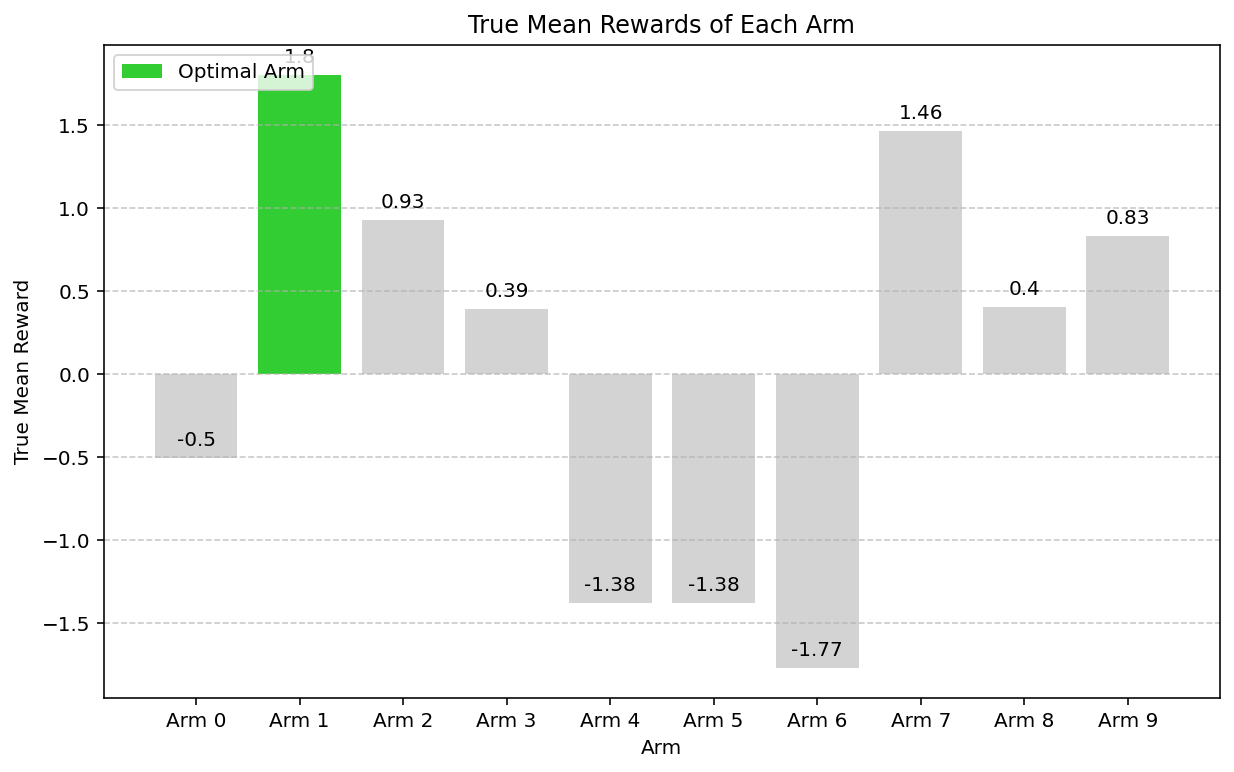

In [23]:
class MultiArmedBandit:
    """
    k-armed bandit with Gaussian reward distributions.
    """
    def __init__(self, k=10, mean_range=(-2, 2), std=1.0):
        """
        Args:
            k: Number of arms
            mean_range: Range for sampling true means
            std: Standard deviation of reward noise
        """
        self.k = k
        self.std = std

        self.true_means = np.random.uniform(
            mean_range[0], mean_range[1], size=k
        )
        self.optimal_arm = np.argmax(self.true_means)
        self.optimal_value = self.true_means[self.optimal_arm]

    def pull(self, arm):
        """Pull an arm and receive a noisy reward."""
        return np.random.normal(self.true_means[arm], self.std)

    def get_regret(self, arm):
        """Calculate regret for choosing this arm."""
        return self.optimal_value - self.true_means[arm]

bandit = MultiArmedBandit(k=10)

plt.figure(figsize=(10, 6))

colors = ['lightgray'] * bandit.k
colors[bandit.optimal_arm] = 'limegreen'

labels = [''] * bandit.k
labels[bandit.optimal_arm] = 'Optimal Arm'
bars = plt.bar(range(bandit.k), bandit.true_means, tick_label=[f'Arm {i}' for i in range(bandit.k)], color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='limegreen', label='Optimal Arm')]
plt.legend(handles=legend_elements, loc='upper left')

plt.xlabel('Arm')
plt.ylabel('True Mean Reward')
plt.title('True Mean Rewards of Each Arm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Action Value Estimation


The value of action $a$ is the true mean reward - $q_*(a)$, we get when choosing $a$. Since, we do not know these values beforehand, we estimate the value of action $a$ using sample averaging:

$$Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}}$$

, where $A_i$ is the action chosen at timestep $i$. At time $t$, $Q_{t}(a)$ denotes the estimate of true mean reward, and is obtained by averaging rewards observed from choosing action $a$ up until time $t$. Suppose at $t+1$, we choose action $a^{'}$, we can simply update $Q_{t+1}(a')$ by:

$$Q_{t+1}(a^{'}) = Q_t(a^{'}) + \frac{1}{n}[R_{t+1} - Q_t(a^{'})]$$

Now, we will discuss some heuristics to maximize total reward. Remember, at timestep $t$, we have a vector of estimated mean rewards for all actions.

## Strategy 1: Greedy

Always select the action with highest estimated value:

$$A_t = \arg\max_a Q_t(a)$$

This exploits current knowledge but never explores. Note, that in theory, this method would still lead $Q(a)$ to converge to $q_{*}(a)$, due to the law of large numbers.

In [24]:
class GreedyAgent:
    """Greedy action selection (pure exploitation)."""
    def __init__(self, k, initial_value=0.0):
        self.k = k
        self.Q = np.full(k, initial_value)  # Estimated values
        self.N = np.zeros(k)  # Action counts

    def select_action(self):
        """Select action with highest estimated value."""
        return np.argmax(self.Q)

    def update(self, action, reward):
        """Update estimates using sample averaging."""
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

## Strategy 2: ε-Greedy

With a small probability $\varepsilon$, explore (random action); otherwise exploit (greedy action):

$$A_t = \begin{cases}
\text{random action} & \text{with probability } \varepsilon \\
\arg\max_a Q_t(a) & \text{with probability } 1-\varepsilon
\end{cases}$$

In [25]:
class EpsilonGreedyAgent:
    """ε-greedy action selection."""
    def __init__(self, k, epsilon=0.1, initial_value=0.0):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.full(k, initial_value)
        self.N = np.zeros(k)

    def select_action(self):
        """Select action using ε-greedy strategy."""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)  # Explore
        else:
            return np.argmax(self.Q)  # Exploit

    def update(self, action, reward):
        """Update estimates."""
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

## Strategy 3: Upper Confidence Bound (UCB)

Suppose the player is operating in the $ϵ$-greedy regime. At each chance of exploration, the player does not prefer any action over another. With the history of knowledge in future, the player has a some idea about which actions are good. Can we use this knowledge of action preference to avoid selecting worse actions at exploration?

$Q_t(a)$ denotes the estimate of $q_{*}(a)$ at time t. Define $\bar{Q}_{t}(a)$ such that,

$$q_{*}(a) < Q_t(a) + \bar{Q}_{t}(a)$$

Trivially, we can set $\bar{Q}_{t}(a)$ to be an extremely large number, but what quality do we want  $\bar{Q}_{t}(a)$ to represent?  $\bar{Q}_{t}(a)$ is a natural representative of action _potential_. The larger  $\bar{Q}_{t}(a)$ is, the larger is the gap between $q_{*}(a)$ and $Q_t(a)$. Moreover, we want the above equation to hold true in high confidence for all possible scenarios.

Suppose we have no knowledge of reward distribution, but we know that its support is bounded. Then, we can make use of Hoeffding's inequality to obtain $\bar{Q}_{t}(a)$. Without stating the inequality here explicitly,

$$P(q_{*}(a) \geq Q_{t}(a) + u)) \leq e^{-2N_{t}(a)u^2}$$

$$ \implies P(q_{*}(a) < Q_{t}(a) + u)) \geq 1 - e^{-2N_{t}(a)u^2}$$


We want the quantity on the right-hand side to be arbitrarily large. Setting some $1 - c$ = 0.99 (say), we can obtain $u = \sqrt{\frac{-log c}{2N_{t}(a)}}$.

As the game rolls out, we want to more sure about choosing good actions at exploration, so one heuristic (UCB1) is to set $c = t^{-4}$ \(followed by absorption of constants into a single $m$\). We get the following algorithm then,


$$A_t = \arg\max_a \left[ Q_t(a) + m\sqrt{\frac{log t}{N_t(a)}} \right]$$

The uncertainty term decreases as an action is selected more often, encouraging exploration of uncertain actions.


In [26]:
class UCBAgent:
    """Upper Confidence Bound action selection."""
    def __init__(self, k, m=2.0, initial_value=0.0):
        self.k = k
        self.m = m
        self.Q = np.full(k, initial_value)
        self.N = np.zeros(k)
        self.t = 0

    def select_action(self):
        """Select action using UCB."""
        self.t += 1

        # Try each action at least once
        if np.min(self.N) == 0:
            return np.argmin(self.N)

        # UCB formula
        ucb_values = self.Q + self.m * np.sqrt(np.log(self.t) / self.N)
        return np.argmax(ucb_values)

    def update(self, action, reward):
        """Update estimates."""
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

## Comparison Experiment

Let's compare all three strategies on the same bandit problem:

In [27]:
def run_experiment(agent, bandit, steps=1000):
    """Run bandit experiment and track performance."""
    rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)

    for t in range(steps):
        action = agent.select_action()
        reward = bandit.pull(action)
        agent.update(action, reward)

        rewards[t] = reward
        optimal_actions[t] = (action == bandit.optimal_arm)

    return rewards, optimal_actions

# Run multiple experiments and average
num_runs = 200
steps = 1000

agents_config = [
    ("Greedy", lambda k: GreedyAgent(k)),
    ("ε-greedy (0.01)", lambda k: EpsilonGreedyAgent(k, epsilon=0.01)),
    ("ε-greedy (0.1)", lambda k: EpsilonGreedyAgent(k, epsilon=0.1)),
    ("UCB (c=2)", lambda k: UCBAgent(k, m=2.0)),
]

results = {}

for name, agent_factory in agents_config:
    print(f"Running {name}...")
    all_rewards = np.zeros((num_runs, steps))
    all_optimal = np.zeros((num_runs, steps))

    for run in range(num_runs):
        bandit = MultiArmedBandit(k=10)
        agent = agent_factory(10)
        rewards, optimal = run_experiment(agent, bandit, steps)
        all_rewards[run] = rewards
        all_optimal[run] = optimal

    results[name] = {
        'rewards': np.mean(all_rewards, axis=0),
        'optimal': np.mean(all_optimal, axis=0)
    }

print("\nDone!")

Running Greedy...
Running ε-greedy (0.01)...
Running ε-greedy (0.1)...
Running UCB (c=2)...

Done!


## Results Visualization

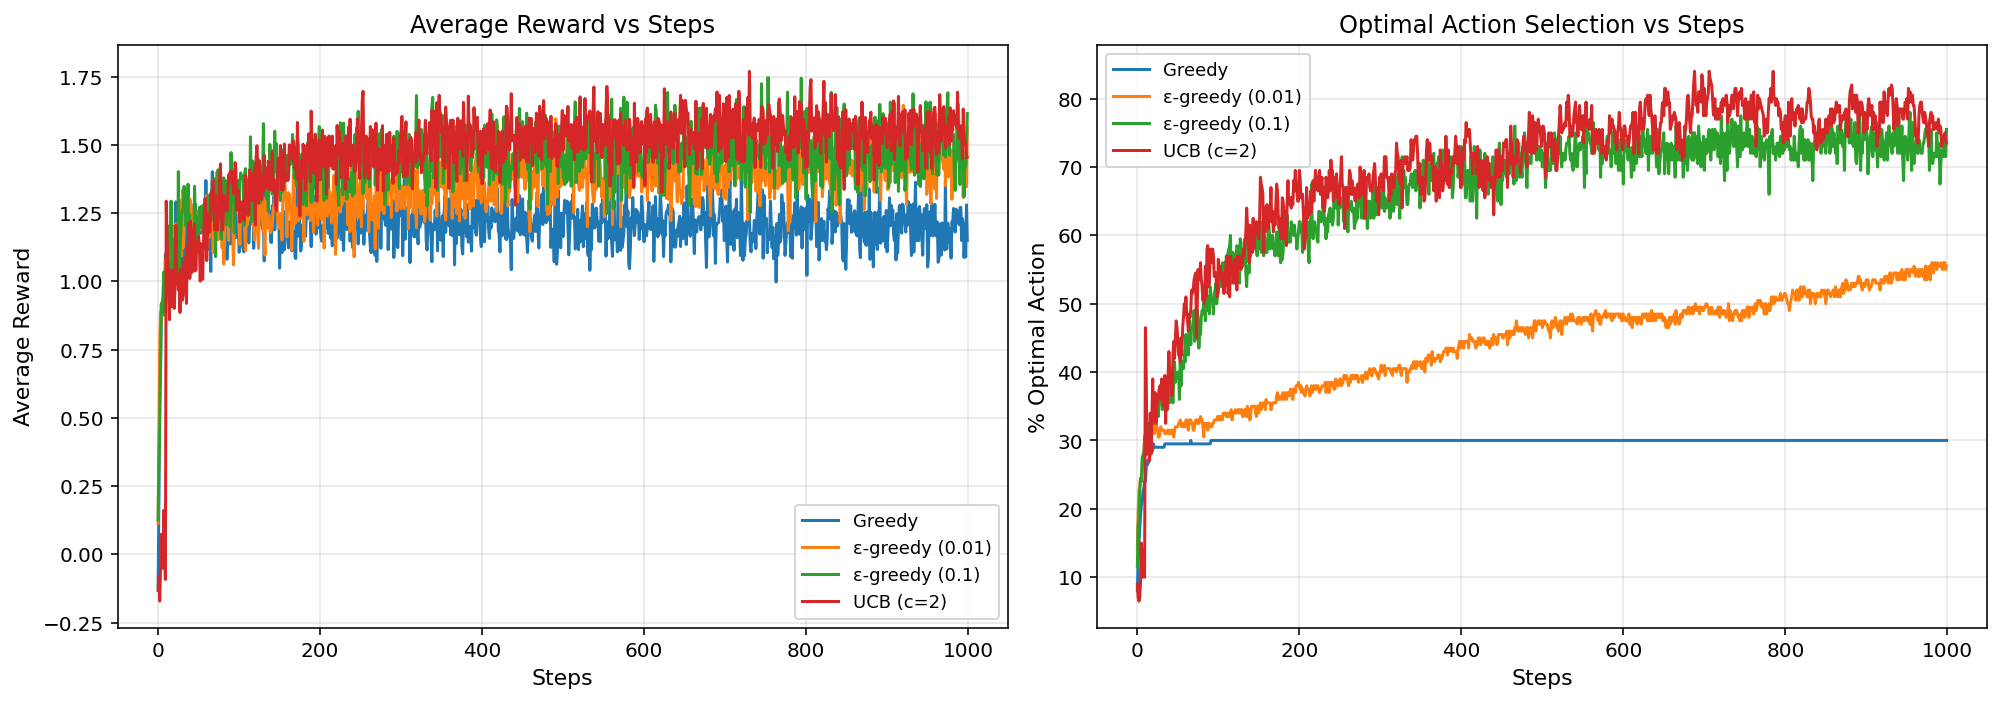


Final Performance (last 100 steps):
  Greedy              : Reward=1.202, Optimal=30.0%
  ε-greedy (0.01)     : Reward=1.461, Optimal=54.3%
  ε-greedy (0.1)      : Reward=1.488, Optimal=73.2%
  UCB (c=2)           : Reward=1.556, Optimal=77.4%


In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Average reward over time
for name in results:
    ax1.plot(results[name]['rewards'], label=name, linewidth=1.5)
ax1.set_xlabel('Steps', fontsize=11)
ax1.set_ylabel('Average Reward', fontsize=11)
ax1.set_title('Average Reward vs Steps', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# % Optimal action
for name in results:
    ax2.plot(results[name]['optimal'] * 100, label=name, linewidth=1.5)
ax2.set_xlabel('Steps', fontsize=11)
ax2.set_ylabel('% Optimal Action', fontsize=11)
ax2.set_title('Optimal Action Selection vs Steps', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Performance (last 100 steps):")
for name in results:
    avg_reward = np.mean(results[name]['rewards'][-100:])
    pct_optimal = np.mean(results[name]['optimal'][-100:]) * 100
    print(f"  {name:20s}: Reward={avg_reward:.3f}, Optimal={pct_optimal:.1f}%")

## Key Insights

1. **Greedy fails** — Gets stuck in suboptimal actions due to no exploration
2. **ε-greedy balances** — Small ε (0.01) exploits more but may underexplore; larger ε (0.1) explores more
3. **UCB excels** — Systematic exploration based on uncertainty, often outperforms fixed ε

The optimal strategy depends on:
- Time horizon (finite vs infinite)
- Reward variance
- Number of arms
- Non-stationarity of environment

## Extensions

- **Non-stationary bandits** — Reward distributions change over time
- **Contextual bandits** — Actions depend on observed context
- **Restless bandits** — Arm states evolve independently
- **Combinatorial bandits** — Select multiple arms simultaneously

Multi-armed bandits form the foundation for more complex RL algorithms like Q-learning and policy gradients.